In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# batch generator and vgg16 model

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
K.set_image_data_format('channels_first')

def get_batches(dirname, gen=ImageDataGenerator(), batch_size=32, shuffle=True, class_mode='categorical'):
    return gen.flow_from_directory(dirname, target_size=(224, 224), batch_size=batch_size, shuffle=shuffle, class_mode=class_mode)

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Lambda, Flatten, Dropout
from keras.layers.convolutional import ZeroPadding2D, Conv2D
from keras.layers.pooling import MaxPooling2D

VGG_MEAN = np.array([123.68, 116.779, 103.939]).reshape((3, 1, 1))
def preprocessing(img):
    img = img - VGG_MEAN
    return img

model = Sequential()
model.add(Lambda(preprocessing, input_shape=(3, 224, 224), output_shape=(3, 224, 224)))
# Layer 1
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 2
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Layer 3
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Layer 4
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Layer 5
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

# take conv layers from vgg16 model

In [3]:
model.load_weights('vgg16_tf.h5')

In [4]:
layers = model.layers
last_conv_idx = [index for index, layer in enumerate(layers) if type(layer) is Conv2D][-1]

In [5]:
conv_model = Sequential(layers[:last_conv_idx+1])

# prepare fully-connected model's input and label

In [6]:
training_batches = get_batches('training', shuffle=False, batch_size=32)
validation_batches = get_batches('validation', shuffle=False, batch_size=32)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [ ]:
validation_classes = validation_batches.classes
training_classes = training_batches.classes

from sklearn.preprocessing import OneHotEncoder
def onehot(x):
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

validation_labels = onehot(validation_classes)
training_labels = onehot(training_classes)

In [7]:
validation_features = conv_model.predict_generator(validation_batches, validation_batches.samples/validation_batches.batch_size, verbose=1)
training_features = conv_model.predict_generator(training_batches, training_batches.samples/training_batches.batch_size, verbose=1)

704/703 [==============================] - 562s   


In [26]:
import bcolz
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]

save_array('training_conv_features.bc', training_features)
save_array('validation_conv_features.bc', validation_features)

In [ ]:
training_features = load_array('training_conv_features.bc')
validation_features = load_array('validation_conv_features.bc')

# create a fully-connected model and reuse vgg16 weights

In [8]:
from keras.optimizers import RMSprop

fc_model = Sequential([
        MaxPooling2D(input_shape=conv_model.output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(2, activation='softmax')
        ])
for l1,l2 in zip(fc_model.layers, layers[last_conv_idx+1:-1]):
    weights = [w/2 for w in l2.get_weights()]
    l1.set_weights(weights)
opt = RMSprop(lr=0.00001, rho=0.7)
fc_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
fc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_6 (MaxPooling2 (None, 512, 7, 7)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dropout_3 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_4 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 8194      
Total para

In [9]:
fc_model.fit(training_features, training_labels, epochs=8, batch_size=16, validation_data=(validation_features, validation_labels))

Train on 22500 samples, validate on 2500 samples
Epoch 1/8
22500/22500 [==============================] - 177s - loss: 0.0912 - acc: 0.9753 - val_loss: 0.0445 - val_acc: 0.9872
Epoch 2/8
22500/22500 [==============================] - 165s - loss: 0.0406 - acc: 0.9909 - val_loss: 0.0650 - val_acc: 0.9836
Epoch 3/8
22500/22500 [==============================] - 165s - loss: 0.0154 - acc: 0.9974 - val_loss: 0.0623 - val_acc: 0.9880
Epoch 4/8
22500/22500 [==============================] - 164s - loss: 0.0064 - acc: 0.9992 - val_loss: 0.1133 - val_acc: 0.9860
Epoch 5/8
22500/22500 [==============================] - 164s - loss: 0.0042 - acc: 0.9997 - val_loss: 0.0857 - val_acc: 0.9876
Epoch 6/8
22500/22500 [==============================] - 164s - loss: 0.0037 - acc: 0.9996 - val_loss: 0.0839 - val_acc: 0.9880
Epoch 7/8
22500/22500 [==============================] - 164s - loss: 0.0035 - acc: 0.9997 - val_loss: 0.0790 - val_acc: 0.9896
Epoch 8/8
22500/22500 [==============================] 

In [15]:
fc_model.save_weights('vgg16_fc_no_dropout.h5')
fc_model.load_weights('vgg16_fc_no_dropout.h5')

# data augamentation

In [18]:
from keras.preprocessing import image

gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True, data_format='channels_last')

In [22]:
from scipy import ndimage

img = np.expand_dims(ndimage.imread('test1/1/7.jpg'),0)
aug_iter = gen.flow(img)

In [23]:
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

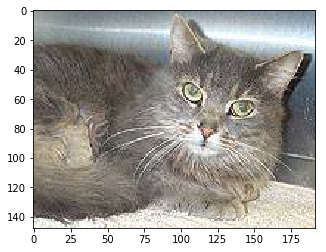

In [25]:
import matplotlib.pyplot as plt
plt.imshow(img[0])

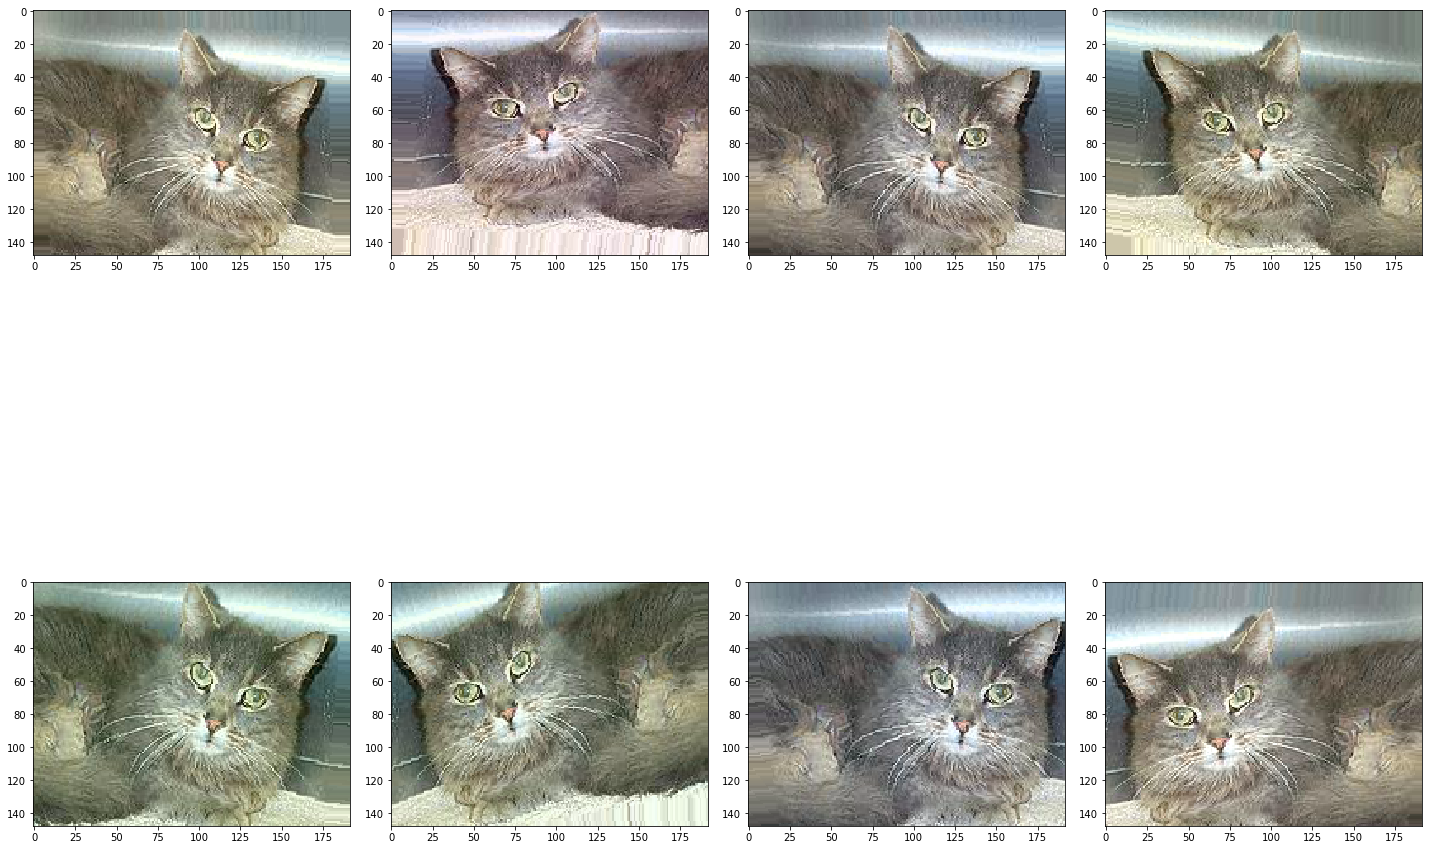

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 20))
axes[0, 0].imshow(aug_imgs[0].astype(np.uint8))
axes[0, 1].imshow(aug_imgs[1].astype(np.uint8))
axes[0, 2].imshow(aug_imgs[2].astype(np.uint8))
axes[0, 3].imshow(aug_imgs[3].astype(np.uint8))
axes[1, 0].imshow(aug_imgs[4].astype(np.uint8))
axes[1, 1].imshow(aug_imgs[5].astype(np.uint8))
axes[1, 2].imshow(aug_imgs[6].astype(np.uint8))
axes[1, 3].imshow(aug_imgs[7].astype(np.uint8))
plt.tight_layout()

In [47]:
K.set_image_data_format('channels_first')

In [48]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [49]:
training_batches = get_batches('training', gen, batch_size=32)
# NB: We don't want to augment or shuffle the validation set
val_batches = get_batches('validation', shuffle=False, batch_size=32)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [50]:
for layer in conv_model.layers:
    layer.trainable = False
conv_model.add(fc_model)

In [52]:
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
conv_model.fit_generator(training_batches,
                         steps_per_epoch=training_batches.samples/training_batches.batch_size,
                         epochs=8, 
                         validation_data=validation_batches,
                         validation_steps=validation_batches.samples/validation_batches.batch_size)

Epoch 1/8
704/703 [==============================] - 543s - loss: 0.3659 - acc: 0.9751 - val_loss: 0.2869 - val_acc: 0.9816
Epoch 2/8
704/703 [==============================] - 554s - loss: 0.3720 - acc: 0.9751 - val_loss: 0.1854 - val_acc: 0.9872
Epoch 3/8
704/703 [==============================] - 553s - loss: 0.3638 - acc: 0.9752 - val_loss: 0.2580 - val_acc: 0.9820
Epoch 4/8
704/703 [==============================] - 551s - loss: 0.3666 - acc: 0.9754 - val_loss: 0.1766 - val_acc: 0.9876
Epoch 5/8
704/703 [==============================] - 550s - loss: 0.3386 - acc: 0.9772 - val_loss: 0.1955 - val_acc: 0.9868
Epoch 6/8
704/703 [==============================] - 549s - loss: 0.3309 - acc: 0.9780 - val_loss: 0.2158 - val_acc: 0.9856
Epoch 7/8
704/703 [==============================] - 542s - loss: 0.3106 - acc: 0.9787 - val_loss: 0.1978 - val_acc: 0.9868
Epoch 8/8
704/703 [==============================] - 541s - loss: 0.3202 - acc: 0.9786 - val_loss: 0.2605 - val_acc: 0.9820


In [53]:
conv_model.save_weights('vgg16_aug1.h5')

In [19]:
conv_model.load_weights('vgg16_aug1.h5')

ValueError: You are trying to load a weight file containing 14 layers into a model with 13 layers.

# batch normalization

https://github.com/zack1030/fast.ai/blob/practice/deeplearning1/nbs/imagenet_batchnorm.ipynb

How do we add batch normalization layers to vgg16
* if we just add bn layers with default parameters
    * we would make activations totally different
    * it also means that the pre-trained weights would be useless
* if we want to keep activations similar
    * we should calculate the parameters (gamma, beta, moving_mean, moving_variance) of these bn layers in advance

However, the original training data of vgg16 is much larger than my storage. Downloading the weights from [fast.ai](https://files.fast.ai/models/vgg16_bn.h5) is forgivable. Of course, we have to convert the kernel to tensorflow again.

In [12]:
from keras.layers.normalization import BatchNormalization
bn_model = Sequential([
        MaxPooling2D(input_shape=conv_model.output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(0.6),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(0.6),
        Dense(1000, activation='softmax')
        ])
bn_model.load_weights('vgg16_bn_fc.h5')
bn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_9 (MaxPooling2 (None, 512, 7, 7)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 4096)              102764544 
_________________________________________________________________
batch_normalization_5 (Batch (None, 4096)              16384     
_________________________________________________________________
dropout_9 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_6 (Batch (None, 4096)              16384     
__________

w1 x (1-prev_p) = w2 x (1-new_p)

In [13]:
def proc_wgts(layer, prev_p, new_p):
    scal = (1-prev_p)/(1-new_p)
    return [o*scal for o in layer.get_weights()]
for l in bn_model.layers:
    if type(l) == Dense: 
        l.set_weights(proc_wgts(l, 0.5, 0.6))

In [14]:
from keras.optimizers import Adam

bn_model.pop()
for layer in bn_model.layers:
    layer.trainable=False

bn_model.add(Dense(2,activation='softmax'))

In [15]:
bn_model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
bn_model.fit(training_features, training_labels, epochs=8, validation_data=(validation_features, validation_labels))

Train on 22500 samples, validate on 2500 samples
Epoch 1/8
22500/22500 [==============================] - 12s - loss: 0.3880 - acc: 0.9324 - val_loss: 0.1144 - val_acc: 0.9788
Epoch 2/8
22500/22500 [==============================] - 12s - loss: 0.4064 - acc: 0.9429 - val_loss: 0.1224 - val_acc: 0.9804
Epoch 3/8
22500/22500 [==============================] - 12s - loss: 0.4421 - acc: 0.9454 - val_loss: 0.1324 - val_acc: 0.9804
Epoch 4/8
22500/22500 [==============================] - 12s - loss: 0.4135 - acc: 0.9522 - val_loss: 0.1350 - val_acc: 0.9796
Epoch 5/8
22500/22500 [==============================] - 12s - loss: 0.4474 - acc: 0.9504 - val_loss: 0.1443 - val_acc: 0.9824
Epoch 6/8
22500/22500 [==============================] - 12s - loss: 0.4829 - acc: 0.9508 - val_loss: 0.1454 - val_acc: 0.9824
Epoch 7/8
22500/22500 [==============================] - 12s - loss: 0.4687 - acc: 0.9526 - val_loss: 0.1853 - val_acc: 0.9784
Epoch 8/8
22500/22500 [==============================] - 12s -

In [17]:
bn_model.save_weights('vgg16_bn_fc_finetune.h5')

In [41]:
bn_model.load_weights('vgg16_bn_fc_finetune.h5')

# merge conv_model and bn_model

In [47]:
final_model = Sequential()
final_model.add(conv_model)
final_model.add(bn_model)
#for layer in bn_model.layers:
#    final_model.add(layer)
for layer in final_model.layers[:-1]:
    layer.trainable = False
for layer in final_model.layers[-1:]:
    layer.trainable = True
#for l1,l2 in zip(bn_model.layers, final_model.layers[last_conv_idx+1:]):
#    l2.set_weights(l1.get_weights())
final_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 512, 14, 14)       14714688  
_________________________________________________________________
sequential_6 (Sequential)    (None, 2)                 119586818 
Total params: 134,301,506
Trainable params: 8,194
Non-trainable params: 134,293,312
_________________________________________________________________


In [43]:
training_batches = get_batches('training', shuffle=True, batch_size=16)
validation_batches = get_batches('validation', shuffle=True, batch_size=16)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [48]:
final_model.evaluate_generator(validation_batches, steps=30)#validation_batches.samples/validation_batches.batch_size)

[0.14951099178846003, 0.98541666666666672]

In [49]:
final_model.evaluate_generator(training_batches, steps=30)#training_batches.samples/training_batches.batch_size)

[0.20733324168141726, 0.97499999999999998]

In [50]:
final_model.fit_generator(training_batches,
                          steps_per_epoch=training_batches.samples/training_batches.batch_size,
                          epochs=1,
                          validation_data=validation_batches,
                          validation_steps=validation_batches.samples/validation_batches.batch_size)

Epoch 1/1
1407/1406 [==============================] - 562s - loss: 0.6368 - acc: 0.9439 - val_loss: 0.1867 - val_acc: 0.9828


In [51]:
final_model.save_weights('vgg16_final1.h5')

In [52]:
final_model.fit_generator(training_batches,
                          steps_per_epoch=training_batches.samples/training_batches.batch_size,
                          epochs=4,
                          validation_data=validation_batches,
                          validation_steps=validation_batches.samples/validation_batches.batch_size)

Epoch 1/4
1407/1406 [==============================] - 559s - loss: 0.6937 - acc: 0.9404 - val_loss: 0.1865 - val_acc: 0.9820
Epoch 2/4
1407/1406 [==============================] - 560s - loss: 0.6916 - acc: 0.9423 - val_loss: 0.2558 - val_acc: 0.9796
Epoch 3/4
1407/1406 [==============================] - 559s - loss: 0.6730 - acc: 0.9445 - val_loss: 0.2444 - val_acc: 0.9804
Epoch 4/4
1407/1406 [==============================] - 562s - loss: 0.6884 - acc: 0.9462 - val_loss: 0.2213 - val_acc: 0.9836


In [53]:
final_model.save_weights('vgg16_final2.h5')

In [55]:
final_model.optimizer.lr=0.000001
final_model.fit_generator(training_batches,
                          steps_per_epoch=training_batches.samples/training_batches.batch_size,
                          epochs=4,
                          validation_data=validation_batches,
                          validation_steps=validation_batches.samples/validation_batches.batch_size)

Epoch 1/4
1407/1406 [==============================] - 562s - loss: 0.7688 - acc: 0.9423 - val_loss: 0.2118 - val_acc: 0.9828
Epoch 2/4
1407/1406 [==============================] - 562s - loss: 0.7690 - acc: 0.9435 - val_loss: 0.2361 - val_acc: 0.9820
Epoch 3/4
1407/1406 [==============================] - 562s - loss: 0.7807 - acc: 0.9439 - val_loss: 0.2213 - val_acc: 0.9840
Epoch 4/4
1407/1406 [==============================] - 562s - loss: 0.7407 - acc: 0.9462 - val_loss: 0.2295 - val_acc: 0.9828


In [56]:
final_model.save_weights('vgg16_final3.h5')